# Body Fat Prediction

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Jupyter Projects\Machine Learning\IBM\Supervised ML\Linear Regression\Datasets\bodyfat.csv")

In [4]:
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Our objective is to predict the ```BodyFat```, so that will be the ```target``` variable, and the rest will be predictor variables

## Data Preprocessing

In [5]:
df.isnull().sum()

Density    0
BodyFat    0
Age        0
Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
dtype: int64

In [7]:
df.duplicated().any()

False

### Outlier Detection in Target Variable

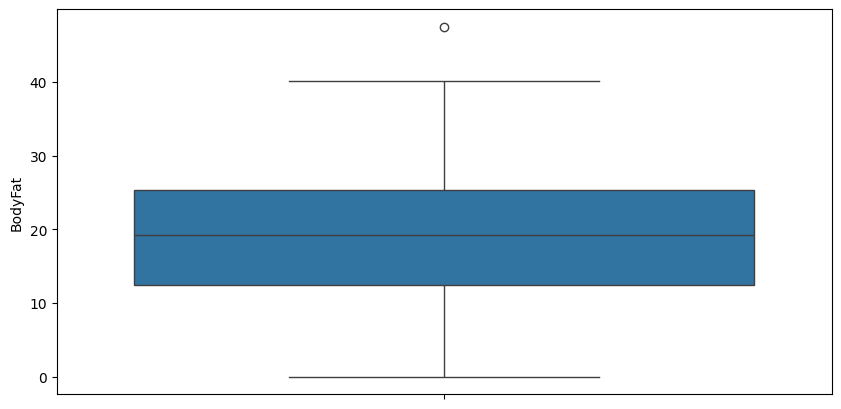

In [139]:
plt.figure(figsize=(10,5))
sns.boxplot(df['BodyFat'])
# plt.tight_layout()
plt.show()

In [160]:
outlier_index = (df[df['BodyFat'] == 47.5]).index
df.drop(outlier_index, axis=0, inplace=True)

## Assumption of Linear Regression

Linear Regression is a parametric approach, so it is based on a few assumptions, which is significant in following them to get a good estimation model.
### 1) Linearity

It is assumed that the independent variables have a linear relationships with the dependent variable, here it is ```BodyFat```.


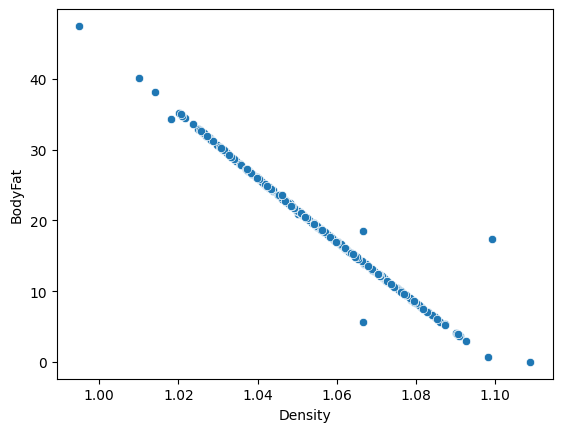

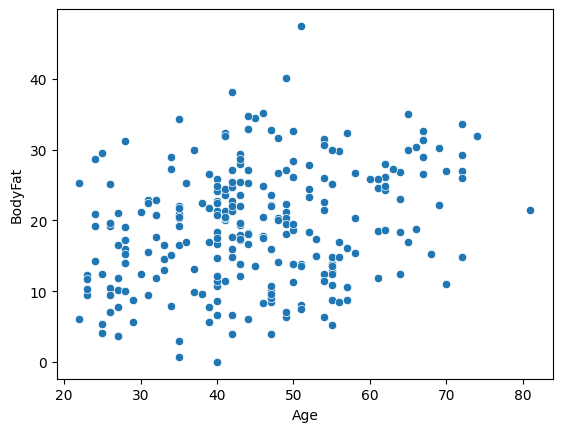

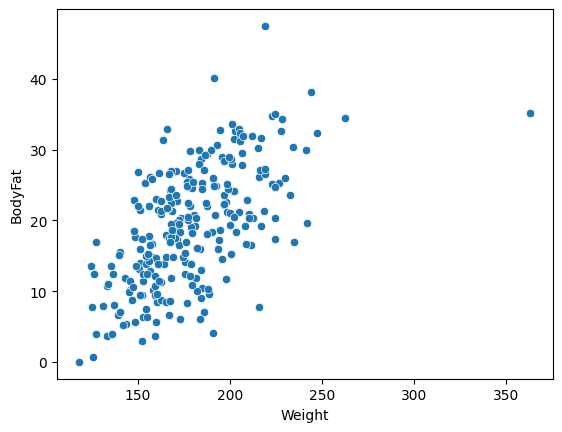

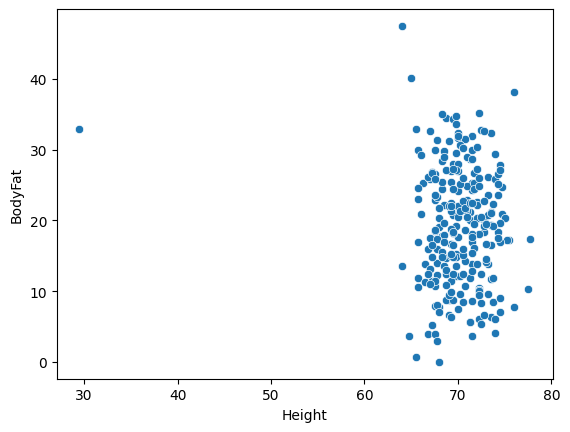

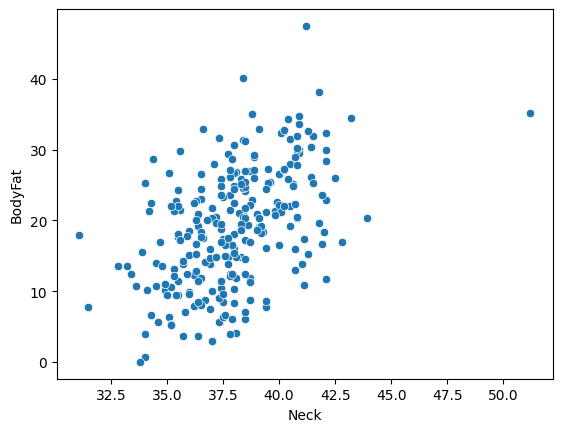

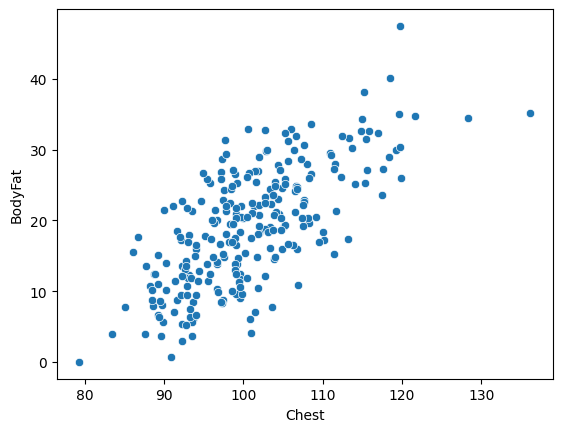

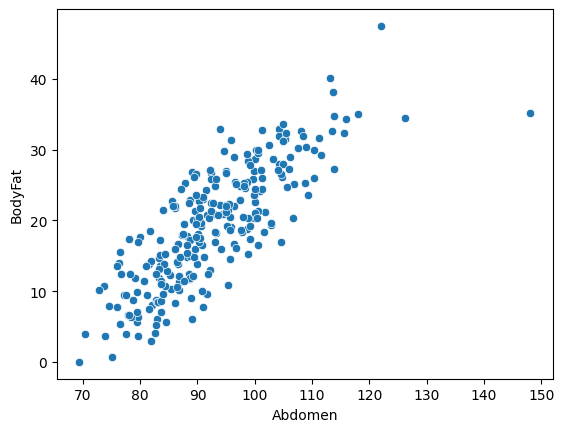

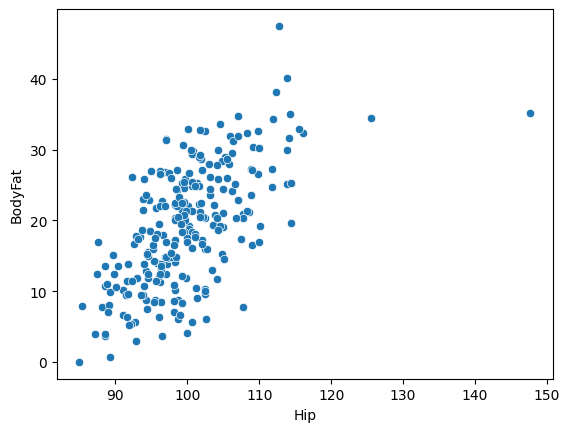

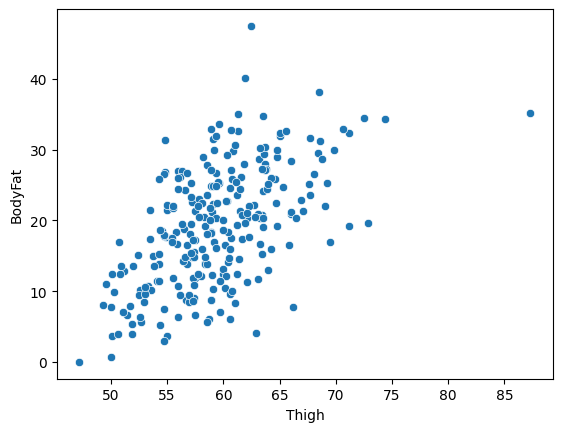

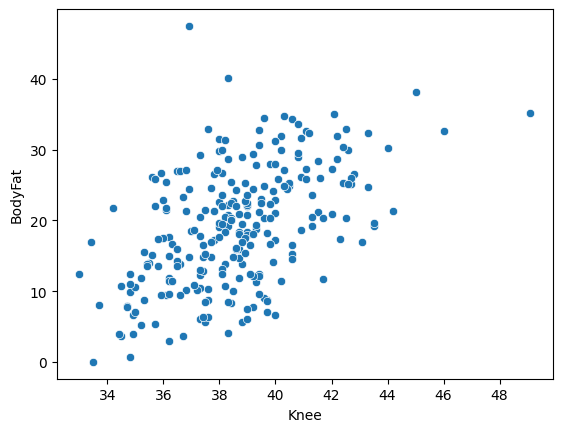

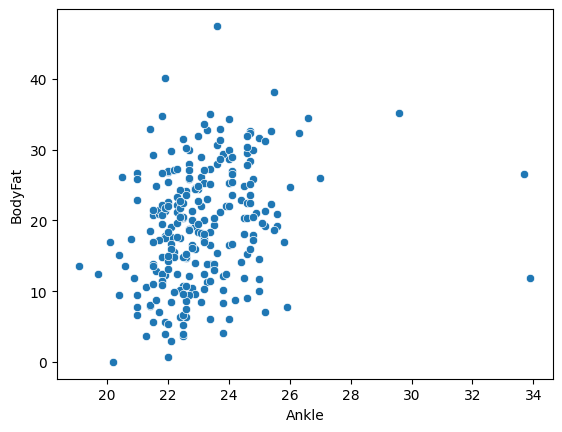

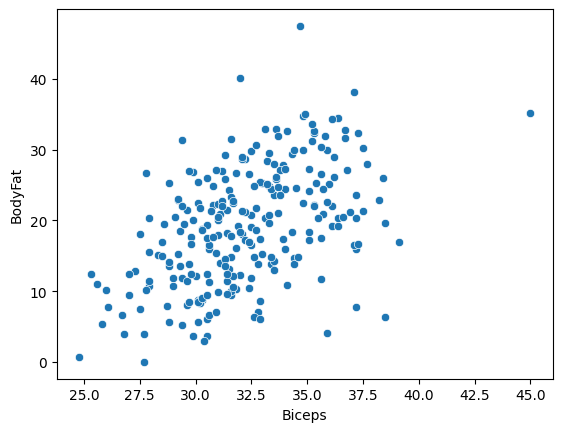

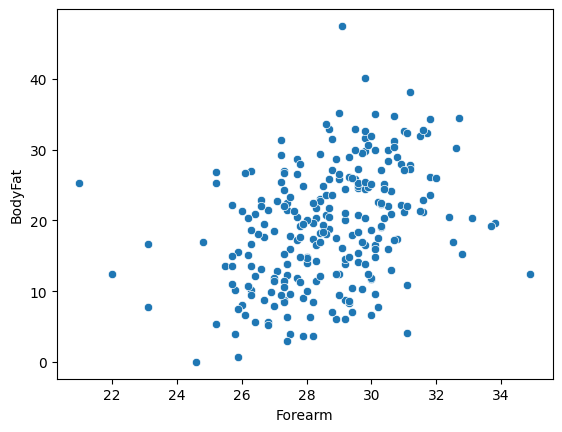

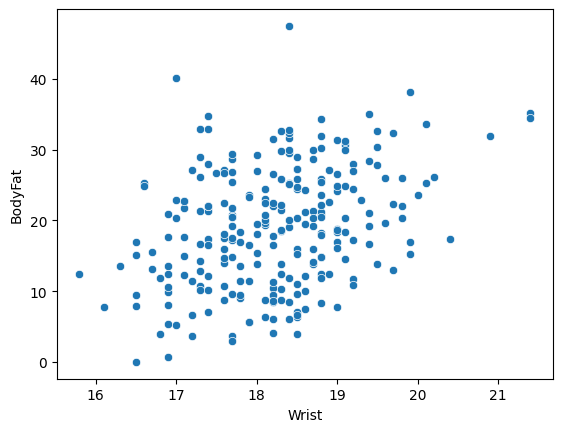

<Figure size 640x480 with 0 Axes>

In [25]:
# plt.figure(figsize=(12,8))
for col in range(0, len(df.columns), 3):
    cols_to_plot = df.columns[col:col+3]
    if 'BodyFat' in cols_to_plot:
        cols_to_plot = cols_to_plot.drop('BodyFat')
    for sub_col in cols_to_plot:
        sns.scatterplot(data=df, x=sub_col, y='BodyFat')
        plt.xlabel(sub_col)
        plt.ylabel('BodyFat')
        plt.show()
plt.tight_layout()

As you can see ```Height``` is not in linear relationship with the ```target``` variable

<Axes: xlabel='Height', ylabel='BodyFat'>

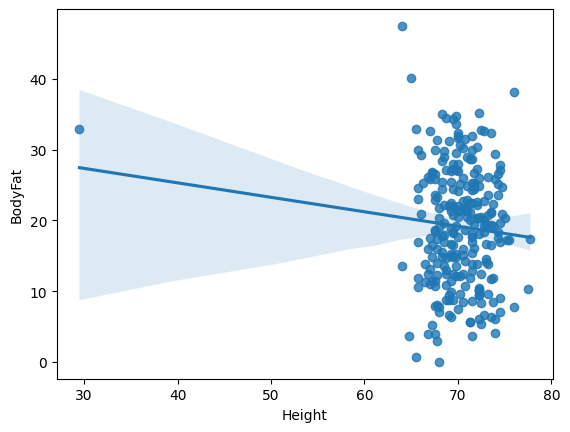

In [26]:
sns.regplot(x=df['Height'], y=df['BodyFat'])

Let's try and apply a few transformation to check if it can be made linear

As this is a simple regression model, and height is not really needed for our objective, so I am going with the simplest approach, that is to delete.

But there's always other methods, like including interaction terms with ```PolynomialFeatures``` to include non-linear relationships and linear relationships into the model, also can use a non-linear models.

In [30]:
df = df.drop('Height', axis=1)
df.head()

,Density,BodyFat,Age,Weight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


<Axes: xlabel='Density', ylabel='BodyFat'>

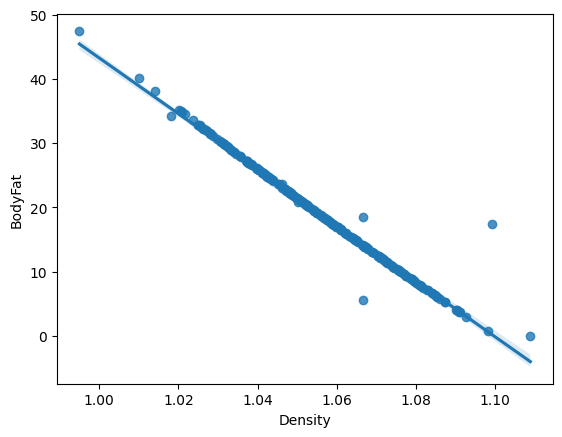

In [51]:
sns.regplot(x=df['Density'], y=df['BodyFat'])

### 2) Normality

The ```target``` variable should be normally distributed. If not, use appropriate transformations and make it normally distributed.

Also we can use D'Agostino's K^2 statistical test to test whether the variable is normally distributed or not.

It is based on the Hypothesis Testing and P-Values:
H0(Null Hypothesis): The data is normally distributed
H1(Alternate Hypothesis): The data is not normally distributed

Default P-value chosen is 0.05,
if the pvalue < 0.05, we reject the null hypothesis,
else we fail to reject the null hypothesis.

<Axes: xlabel='BodyFat', ylabel='Density'>

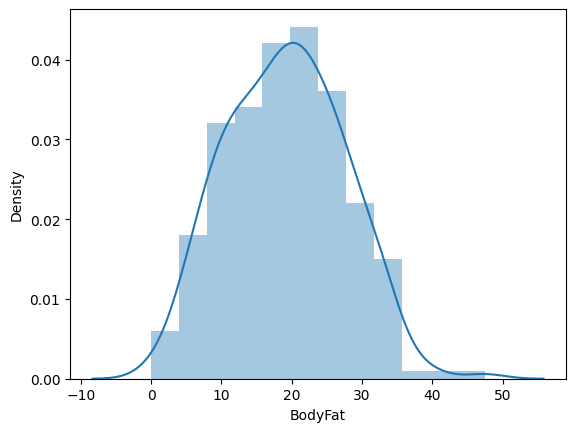

In [31]:
sns.distplot(df['BodyFat'])

In [32]:
from scipy.stats.mstats import normaltest

In [33]:
normaltest(df['BodyFat'])

NormaltestResult(statistic=2.3601063304419294, pvalue=0.3072624024933559)

*__Conclusion__*: The pvalue is > 0.05, so we fail to reject the null hypothesis of the data being normally distributed.

### 3) Multicollinearity

It assumes that there should not be any strong correlation between the independent features. If it does, then the model wouldn't know which feature is infulencing the target variable. 

In [41]:
corr_mat = df.drop('BodyFat', axis=1).corr() # Target variable is not required when performing for multicollinearity between features
corr_mat

,Density,Age,Weight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
Density,1.000000,-0.277637,-0.594062,-0.472966,-0.682599,-0.798955,-0.609331,-0.553091,-0.495040,-0.264890,-0.487109,-0.351648,-0.325716
Age,-0.277637,1.000000,-0.012746,0.113505,0.176450,0.230409,-0.050332,-0.200096,0.017516,-0.105058,-0.041162,-0.085056,0.213531
Weight,-0.594062,-0.012746,1.000000,0.830716,0.894191,0.887995,0.940884,0.868694,0.853167,0.613685,0.800416,0.630301,0.729775
Neck,-0.472966,0.113505,0.830716,1.000000,0.784835,0.754077,0.734958,0.695697,0.672405,0.477892,0.731146,0.623660,0.744826
Chest,-0.682599,0.176450,0.894191,0.784835,1.000000,0.915828,0.829420,0.729859,0.719496,0.482988,0.727907,0.580173,0.660162
Abdomen,-0.798955,0.230409,0.887995,0.754077,0.915828,1.000000,0.874066,0.766624,0.737179,0.453223,0.684983,0.503316,0.619832
Hip,-0.609331,-0.050332,0.940884,0.734958,0.829420,0.874066,1.000000,0.896410,0.823473,0.558387,0.739273,0.545014,0.630090
Thigh,-0.553091,-0.200096,0.868694,0.695697,0.729859,0.766624,0.896410,1.000000,0.799170,0.539797,0.761477,0.566842,0.558685
Knee,-0.495040,0.017516,0.853167,0.672405,0.719496,0.737179,0.823473,0.799170,1.000000,0.611608,0.678709,0.555898,0.664507
Ankle,-0.264890,-0.105058,0.613685,0.477892,0.482988,0.453223,0.558387,0.539797,0.611608,1.000000,0.484855,0.419050,0.566195


Usually, by default, the data science practitioners use 0.75 as the threshold for finding the collinearity between the features, so I am going to use the same threshold for picking out the collinear features

In [42]:
abs(corr_mat) > .75

,Density,Age,Weight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
Density,True,False,False,False,False,True,False,False,False,False,False,False,False
Age,False,True,False,False,False,False,False,False,False,False,False,False,False
Weight,False,False,True,True,True,True,True,True,True,False,True,False,False
Neck,False,False,True,True,True,True,False,False,False,False,False,False,False
Chest,False,False,True,True,True,True,True,False,False,False,False,False,False
Abdomen,True,False,True,True,True,True,True,True,False,False,False,False,False
Hip,False,False,True,False,True,True,True,True,True,False,False,False,False
Thigh,False,False,True,False,False,True,True,True,True,False,True,False,False
Knee,False,False,True,False,False,False,True,True,True,False,False,False,False
Ankle,False,False,False,False,False,False,False,False,False,True,False,False,False


<Axes: >

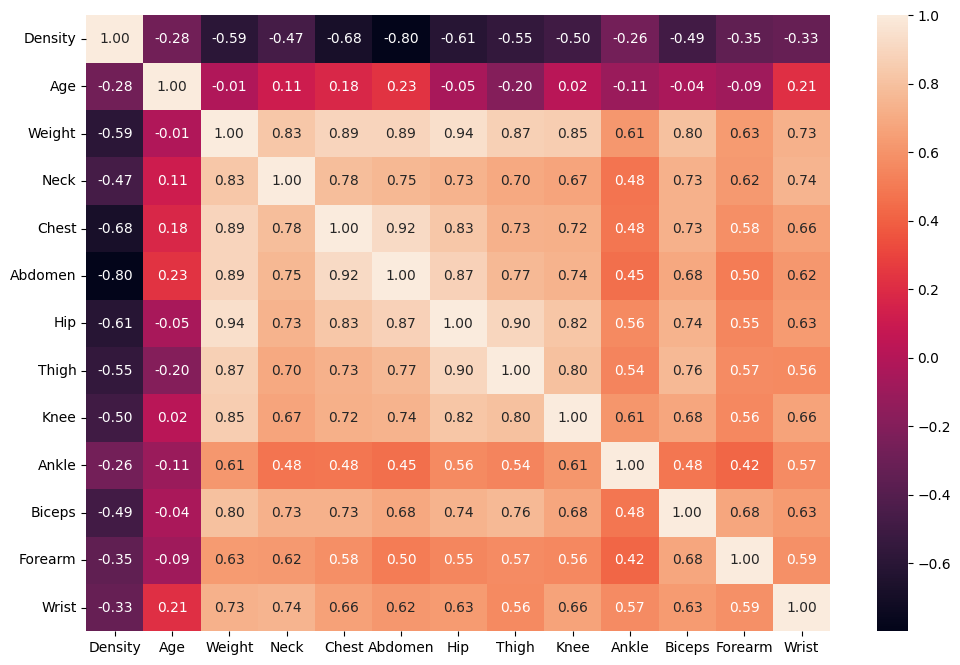

In [43]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat, annot=True, cmap='rocket', fmt=".2f")

As you can see there are a few features that are collinear, so this could affect our model's accuracy

## Testing the Regression without the PolynomialFeatures

Now, it's time to perform the regression analysis

In [45]:
X = df.drop('BodyFat', axis=1)
Y = df['BodyFat']
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X: (252, 13)
Shape of Y: (252,)


In [47]:
X.head()

,Density,Age,Weight,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,23,154.25,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,22,173.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,22,154.00,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,26,184.75,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,24,184.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [48]:
Y.head()

0    12.3
1     6.1
2    25.3
3    10.4
4    28.7
Name: BodyFat, dtype: float64

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=0)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (176, 13)
Testing data shape: (76, 13)


### Scaling the data

By scaling the data we can maintain the consistency across the features

In [63]:
scaler = StandardScaler()

In [64]:
X_train_s = scaler.fit_transform(X_train)

array([[ 0.09574938,  0.54243505,  0.77077417, ...,  0.96119208,
         0.51365302,  0.89516318],
       [ 1.39604959,  0.46307631, -0.83895306, ..., -1.58472975,
        -1.37612577,  0.36505309],
       [-1.09532562, -1.67960978,  0.1433933 , ..., -0.01027809,
        -0.45677393, -0.58914508],
       ...,
       [ 0.62627187,  0.46307631, -0.02996194, ...,  0.39170956,
         0.61580322,  1.31925126],
       [ 0.59506466, -0.48922862, -1.03707333, ..., -1.14924312,
        -0.91644985, -0.37710104],
       [-0.15390826, -0.80666359, -0.08774702, ..., -0.41226575,
         0.0539771 , -0.58914508]])

### Fitting the regression

In [67]:
linearReg = LinearRegression()
linearReg.fit(X_train_s, Y_train)

LinearRegression()

### Testing the data

We need to scale the data as well, but no need to fit the scaler object again, as we need consistent format, so we will use the already fitted object on training set to the testing set

In [119]:
X_test_s = scaler.transform(X_test)
y_pred = linearReg.predict(X_test_s)

In [120]:
r2_score(Y_test, y_pred)

0.9881116676821579

We have obtained the accuracy of ```98%``` for the coefficient of determination, i.e., ```R^2``` coefficient.

---


## Testing the Regression with PolynomialFeatures

### Fitting the polynomial features

In [71]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [74]:
new_x = df.drop('BodyFat', axis=1)
new_y = df.BodyFat

In [75]:
new_x_poly = poly.fit_transform(new_x)

In [76]:
new_x.shape

(252, 13)

In [77]:
new_x_poly.shape

(252, 104)

In [90]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_x_poly, new_y, test_size=.3, random_state=0)

### Standardizing the features using StandardScaler()

In [81]:
from sklearn.preprocessing import StandardScaler

In [91]:
new_scaler = StandardScaler()

In [92]:
new_X_train_s = new_scaler.fit_transform(new_X_train)

### Fitting the Regression with Polynomial Features

In [85]:
new_linearReg = LinearRegression()

In [93]:
new_linearReg.fit(new_X_train_s, new_y_train)

LinearRegression()

### Testing the data

In [94]:
new_X_test_s = new_scaler.transform(new_X_test)

In [98]:
new_y_pred = new_linearReg.predict(new_X_test_s)
new_y_pred

array([ 4.71381887, 27.90064365,  4.0156569 , 19.87495269,  7.58468153,
       22.90801525, 25.45824297, 25.22363655, 25.96124901, 26.54180441,
       27.09027595, 14.65044799, 22.60179708, 19.97852693, 15.91892409,
       12.03983248, 12.02030493,  1.29278521, 10.12502717, 11.15172214,
       21.5894109 , 13.12715042, 29.04705134, 21.75091948, 20.18980664,
       32.08479995,  5.01413775, 21.49425883, 21.76134248, 27.80627579,
       30.81597227, 26.34694066, 29.11122942, 11.80432151, 35.39945261,
       14.33830577, 24.25947675, 21.88574002, 15.02906111, 10.68650412,
       16.57278537, 20.89823482, 32.4006084 , 21.89982656, 20.26674041,
       14.74278654, 13.25216154,  6.78345423, 30.6216965 , -1.91923137,
        9.08253692, 12.09257988, 21.92324832,  8.22840406, 24.05635125,
       13.06183731, 15.90535318, 17.17939941, 24.01614289, 21.02688485,
        7.72786964, 11.43693814, 10.39755542, 13.01967128, 15.06296974,
       15.14957837, 21.67674261, 19.58289861, 33.59400805, 14.44

In [99]:
r2_score(new_y_test, new_y_pred)

0.960796811456941

This concludes that incorporating Polynomial Features is not enhancing, but decreasing the model's performance, in this case only. Not in general way.

---

## Creating Pipeline for fast computations

In [100]:
from sklearn.pipeline import Pipeline

In [188]:
steps = [('wo_den_scaler', StandardScaler()), ('wo_den_linearReg', LinearRegression())]

In [189]:
pipe = Pipeline(steps=steps)

## Testing the Regression without ```Density``` feature using a Pipeline

In [97]:
X_wo_den = df.drop(['Density','BodyFat'], axis=1)
Y_wo_den = df.BodyFat

In [103]:
X_wo_den_train, X_wo_den_test, Y_wo_den_train, Y_wo_den_test = train_test_split(X_wo_den, Y_wo_den, test_size=.3, random_state=0)

In [104]:
pipe.fit(X_wo_den_train, Y_wo_den_train)

Pipeline(steps=[('wo_den_scaler', StandardScaler()),
                ('wo_den_linearReg', LinearRegression())])

In [107]:
Y_wo_den_pred = pipe.predict(X_wo_den_test)
Y_wo_den_pred

array([12.30465699, 21.08784321, 11.80447841, 20.19005402,  8.8882504 ,
       17.96116846, 17.71984568, 21.32309597, 27.12375451, 27.38510341,
       26.83214245, 16.03197613, 21.23329961, 22.84086782, 17.06383165,
       11.42058322, 14.79297955,  8.34390207, 15.50558321, 15.84216787,
       21.89327759,  9.64958984, 25.61078428, 18.00921609, 19.29935521,
       26.41683208,  9.74979239, 23.89281275, 17.10357461, 21.45353063,
       30.22936963, 22.00010564, 33.33605318, 16.75636418, 38.32778014,
       13.0785576 , 27.80614267, 16.70483007,  9.59079893, 10.3072177 ,
       21.34454031, 18.263899  , 36.91555456, 20.64279457, 21.79513922,
       15.16782779, 13.83186737, 11.11075283, 29.78287596,  4.519904  ,
       12.50448367, 15.44836543, 19.06559529,  7.84920362, 26.24275406,
       16.08277051, 20.28034666, 17.02795451, 30.54012906, 23.58000425,
        3.88944388, 16.85589001, 14.24866108, 13.56997347, 18.11480049,
       13.26177052, 23.32640053, 12.16582898, 28.91200865, 18.87

In [106]:
r2_score(Y_wo_den_test, Y_wo_den_pred)

0.7563489699455348

We obtained a signficant decrease from ```98%``` to ```75%``` in the model's accuracy after dropping the ```Density``` feature.

Conclusion: ```Density``` factor also affects significantly in the predicting the body fat percentage

## Model Validation

To validate the model's efficiency, we need to check that the residuals/error values are normally distributed. If not, the model cannot be validated or the model is biased.

We will use visualizations to check the residuals for the "with density model" and "without density model"

Text(0.5, 0.98, 'Residual Distriution')

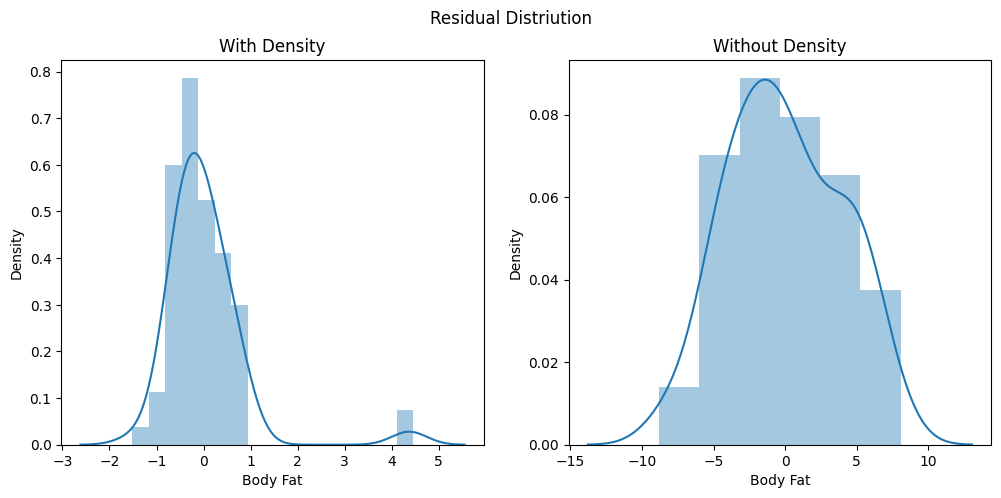

In [172]:
with_density_residual = Y_test - y_pred
without_density_residual = residuals = Y_wo_den_test - Y_wo_den_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(with_density_residual, ax=ax1)
sns.distplot(without_density_residual, ax=ax2)
ax1.set(title='With Density', xlabel='Body Fat')
ax2.set(title='Without Density', xlabel='Body Fat')
fig.suptitle('Residual Distriution')

In [174]:
print(f"With density pvalue result: {normaltest(with_density_residual)[1]}")
print(f"Without density pvalue result: {normaltest(without_density_residual)[1]}")

With density pvalue result: 3.0596248265561622e-18
Without density pvalue result: 0.11885710658150814


__Conclusion:__ Although the model's accuracy is low when the density feature is dropped, but the model can be validated and the residuals are normally distributed. But when the density is incorporated and the model's accuracy is significantly higher, but the resiudals are non-normally distributed, this could affect the validation of the model.

---

## Prediction using New Data

In [201]:
# Enter all the data manually

density = float(input("Enter density:"))
age = int(input("Enter age(years):"))
weight = float(input("Enter weight(lbs):"))
neck = float(input("Enter neck size(cm):"))
chest = float(input("Enter chest size(cm):"))
abdomen = float(input("Enter abdomen size(cm):"))
hip = float(input("Enter hip size(cm):"))
thigh = float(input("Enter thigh size(cm):"))
knee = float(input("Enter knee size(cm):"))
ankle = float(input("Enter ankle size(cm):"))
biceps = float(input("Enter biceps size(cm):"))
forearm = float(input("Enter forearm size(cm):"))
wrist = float(input("Enter wrist size(cm):"))

Enter density: 


ValueError: could not convert string to float: ''

In [181]:
dataset = {
    'Density':[density],
    'Age':[age],
    'Weight':[weight],
    'Neck':[neck],
    'Chest':[chest],
    'Abdomen':[abdomen],
    'Hip':[hip],
    'Thigh':[thigh],
    'Knee':[knee],
    'Ankle':[ankle],
    'Biceps':[biceps],
    'Forearm':[forearm],
    'Wrist':[wrist]}
new_data = pd.DataFrame(dataset)

In [193]:
wo_den_scaler = StandardScaler()
new_data_s = wo_den_scaler.fit_transform(new_data)

In [194]:
new_pred_y = linearReg.predict(new_data_s)

In [200]:
print(f"The predicted body fat: {str(new_pred_y).strip('[]')}%")

The predicted body fat: 19.37556818%


# Thank you!